# Filtros FIR

Para crear un filtro FIR, debemos seguir los pasos:
1. Definir frecuencias que se desea eliminar: pasa bajo $[0,f]$, pasa alto $[f,f_m]$, pasa banda $[f_1,f_2]$, rechaza banda $[0,f_1)(f_2,f_m]$
2. Antitransformar
3. Aplicar ventana de N muestras (cualquiera)
4. Aplicar desplazamiento de $\frac{N-1}{2}$ muestras. Para esto utilizar la propiedad de retardo de la TDF
$$x[n-i] \xLeftrightarrow{\mathcal{F}} X[k]e^{-j\omega i}$$
Obviamente vamos a aplicarlo antes de antitransformar, pero se menciona aca para que se entienda el por qué.

5. Obtener respuesta al impulso

# Rechaza banda

c:\Users\lusau\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\lusau\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


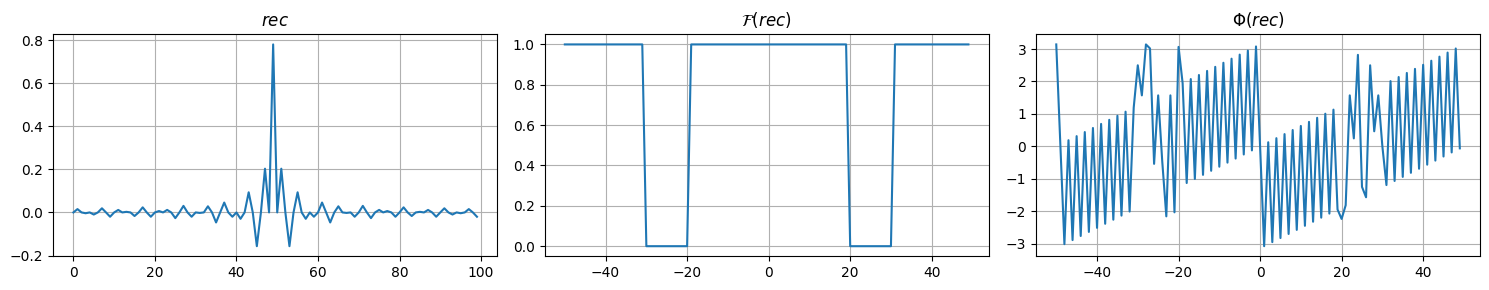

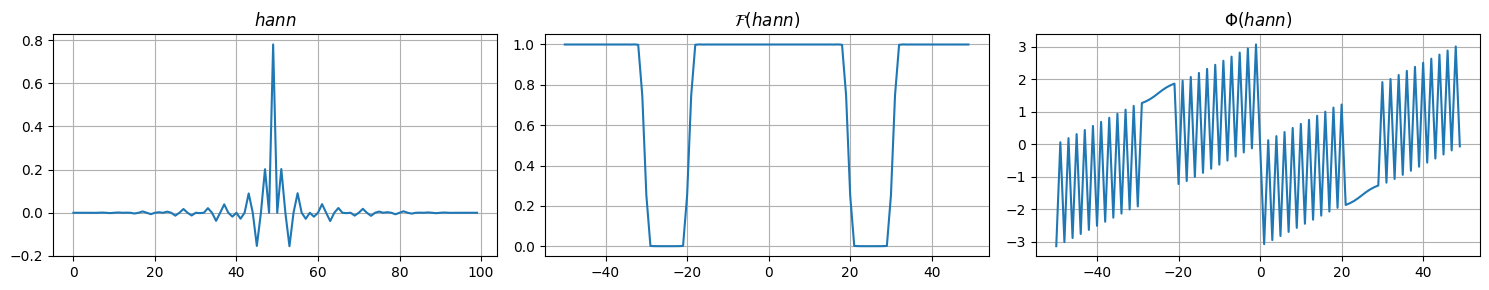

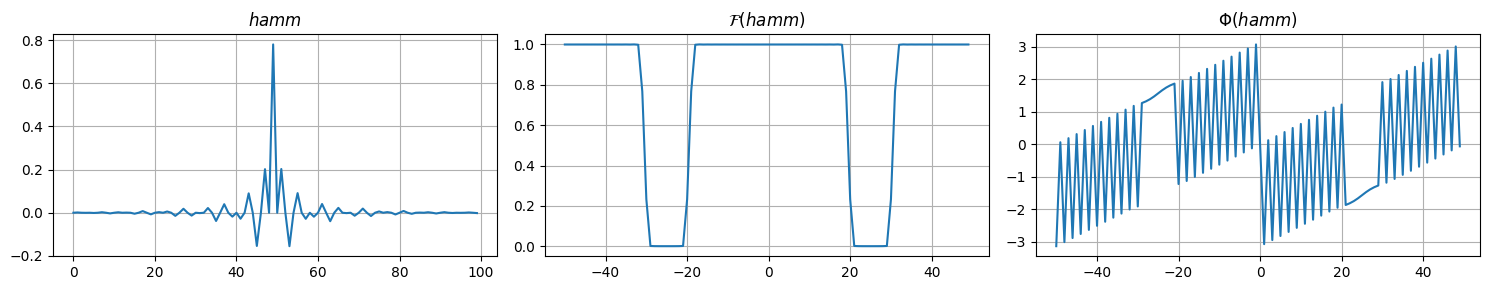

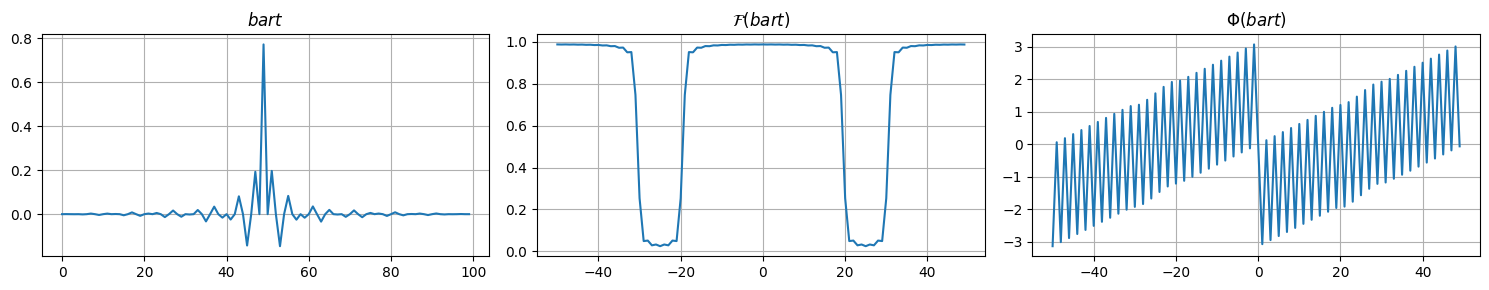

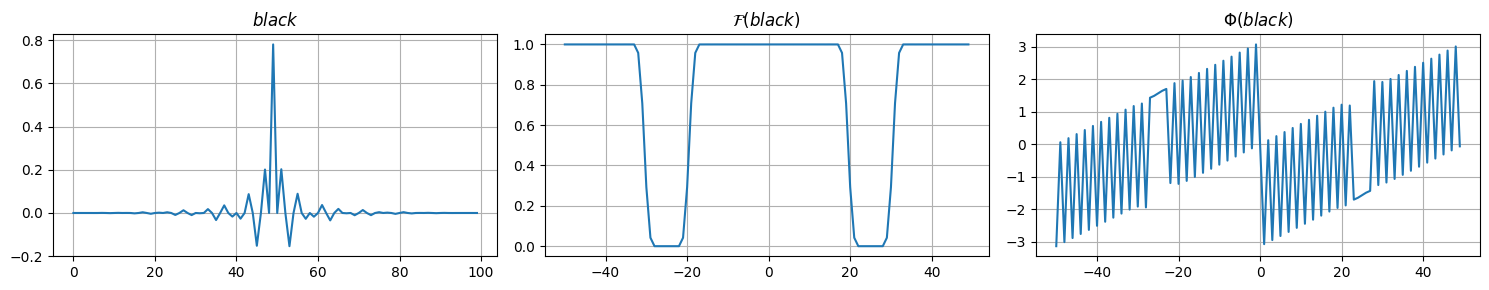

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin
from testFiltro import testFiltro

def rectangular(s,Nini,Nfin):
    '''Ventana rectangular aplicada a s entre las muestras Nini y Nfin'''
    w = np.ones(Nfin-Nini)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hann(s,Nini,Nfin):
    '''Ventana de Hann aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [0.5 for _ in range(N)] - 0.5 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hamming(s,Nini,Nfin):
    '''Ventana de Hamming aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [27/50 for _ in range(N)] - 23/50 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def bartlett(s,Nini,Nfin):
    '''Ventana de Bartlett aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2.0/N
    w = np.where(np.less_equal(n,N/2.0),n*aux,[2 for _ in range(N)] - n*aux)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def blackman(s,Nini,Nfin):
    '''Ventana de Blackman aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [21/50 for _ in range(N)] - 0.5*np.cos(aux*n) + (2/25)*np.cos(2*aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def pasaaltoFreq(N,fmin, fmax):
    '''genera el espectro idea de un filtro rechaza banda'''
    f = np.arange(N)
    dAng = 2*np.pi/N
    pasatodo = [np.cos(k*dAng) + 1j*np.sin(k*dAng) for k in f]
    pasanada = np.multiply(pasatodo,np.zeros(N))
    H = np.where(np.less(f,fmin),pasatodo,pasanada)                               # [0:fmin]
    H = np.where(np.logical_and(np.greater(f,fmax),np.less(f,N-fmax)), pasatodo, H)   # [fmax:fm-fmax]
    H = np.where(np.greater(f,N-fmin),pasatodo,H)                                   # [fm-fmin:fm]
    return H

def retardar(X,i):
    N = len(X)
    k = np.arange(N)
    exp = np.exp(-2j*np.pi*k*i/N)
    Xret = X*exp
    return Xret

def FIRRechazaBanda(fmin,fmax,N,W,sobremuestreo=10):
    '''Genera un h[n] de un filtro pasa bajo para frecuencias <= f, con duracion N muestras y aplicando la ventana W'''
    M = N*sobremuestreo
    debug = False
    fig = 0
    ax = 0

    if debug:
        fig = plt.figure()
        ax = [
            plt.subplot2grid([4,2],[0,0]),  # F mod
            plt.subplot2grid([4,2],[0,1]),  # F ang
            plt.subplot2grid([4,2],[1,0]),  # Fr mod
            plt.subplot2grid([4,2],[1,1]),  # Fr ang
            plt.subplot2grid([4,1],[2,0]),  # x[n]
            plt.subplot2grid([4,1],[3,0]),  # x[n]w[n]
        ]
        for axi in ax:
            axi.grid()
        fig.set_figheight(10)
        fig.set_figwidth(15)

    # Generar respuesta en frecuencia deseada
    X = pasaaltoFreq(M,fmin,fmax)
    if debug:
        ax[0].plot(np.abs(X))
        ax[1].plot(np.angle(X))

    # Aplicar retardo
    X = retardar(X,(M-1 if M%2 != 0 else M)/2.0)
    if debug:
        ax[2].plot(np.abs(X))
        ax[3].plot(np.angle(X))

    # Antitransformar
    x = np.fft.ifft(X)
    if debug:
        ax[4].plot(x)

    # Aplicar ventana
    x = W(x,0,M)
    if debug:
        ax[5].plot(x)

    # Devolver downsampleada y modulada por el sobremuestreo
    muestras = np.arange(N)*sobremuestreo
    return sobremuestreo*x[muestras]

# Parametros
fm = 300
bandaMin = 20
bandaMax = 30
longitud = 100

hrectangular = FIRRechazaBanda(bandaMin,bandaMax,longitud,rectangular,sobremuestreo=1)
hhann = FIRRechazaBanda(bandaMin,bandaMax,longitud,hann,sobremuestreo=1)
hhamming = FIRRechazaBanda(bandaMin,bandaMax,longitud,hamming,sobremuestreo=1)
hbartlett = FIRRechazaBanda(bandaMin,bandaMax,longitud,bartlett,sobremuestreo=1)
hblackman = FIRRechazaBanda(bandaMin,bandaMax,longitud,blackman,sobremuestreo=1)

testFiltro(hrectangular,'rec')
testFiltro(hhann,'hann')
testFiltro(hhamming,'hamm')
testFiltro(hbartlett,'bart')
testFiltro(hblackman,'black')

# Rechaza banda con sobremuestreo

c:\Users\lusau\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\lusau\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


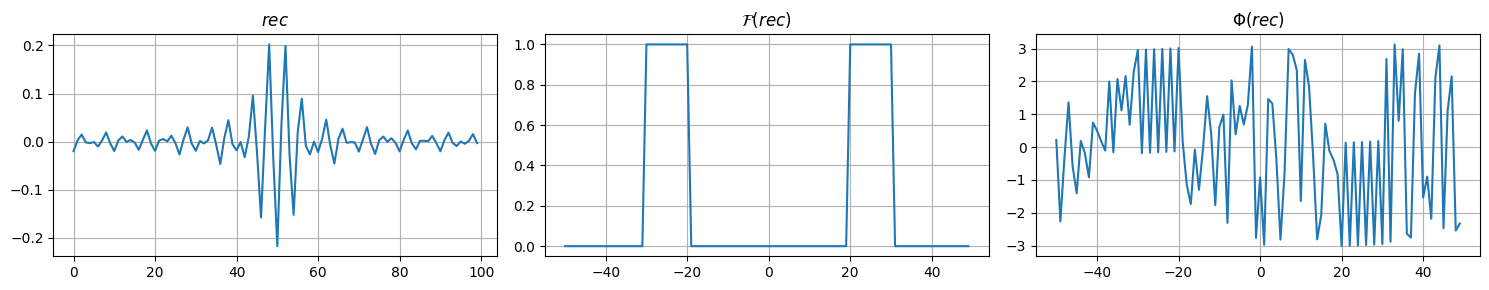

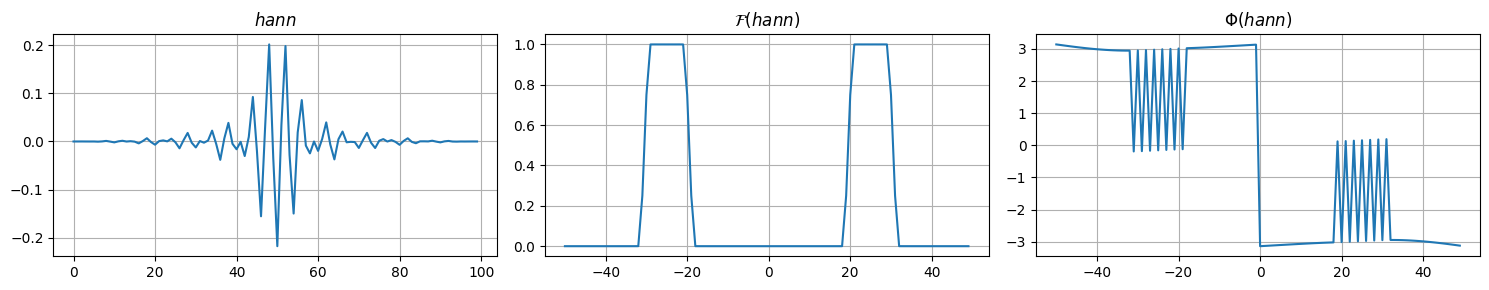

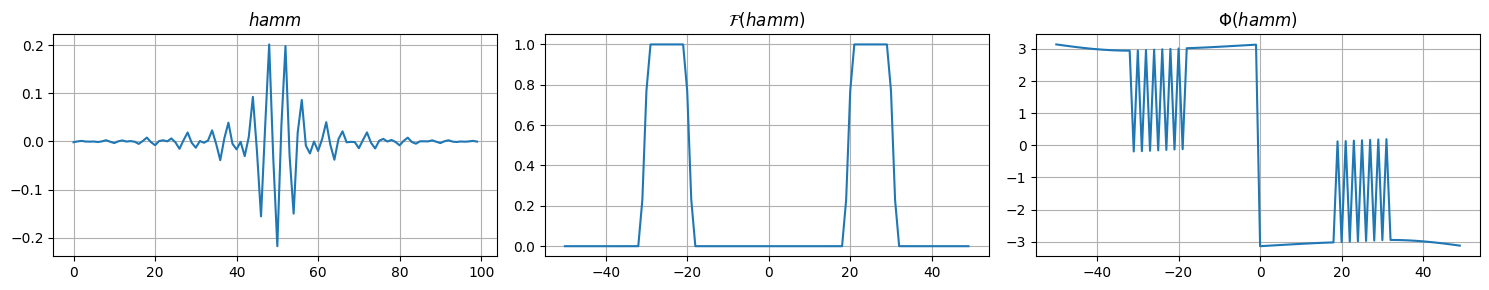

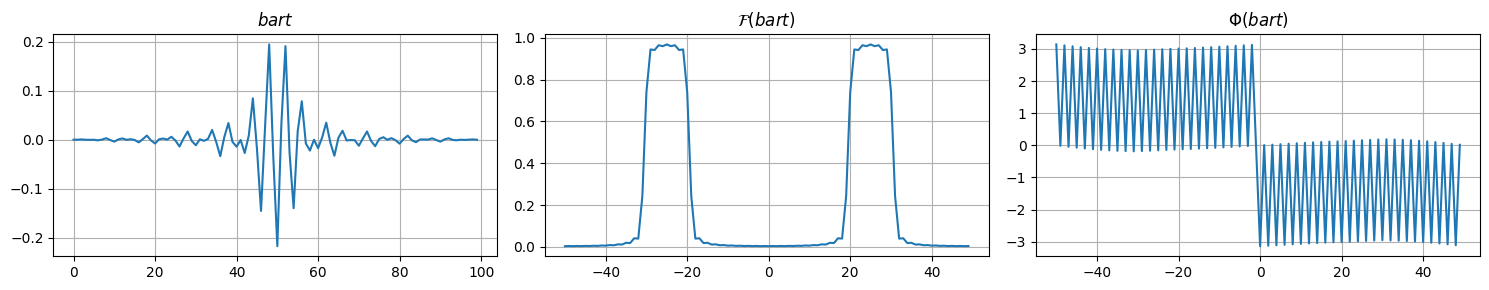

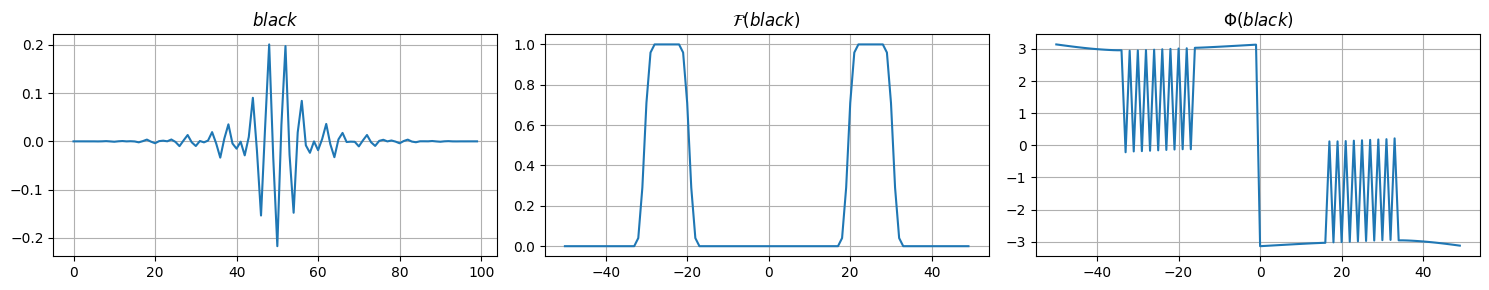

In [36]:
hrectangular = FIRRechazaBanda(bandaMin,bandaMax,longitud,rectangular)
hhann = FIRRechazaBanda(bandaMin,bandaMax,longitud,hann)
hhamming = FIRRechazaBanda(bandaMin,bandaMax,longitud,hamming)
hbartlett = FIRRechazaBanda(bandaMin,bandaMax,longitud,bartlett)
hblackman = FIRRechazaBanda(bandaMin,bandaMax,longitud,blackman)

testFiltro(hrectangular,'rec')
testFiltro(hhann,'hann')
testFiltro(hhamming,'hamm')
testFiltro(hbartlett,'bart')
testFiltro(hblackman,'black')

In [ ]:
def FIRPasaBajo(fmax,N,W,sobremuestreo=10):
    '''Genera un h[n] de un filtro pasa bajo para frecuencias <= f, con duracion N muestras y aplicando la ventana W'''
    M = N*sobremuestreo
    debug = False
    fig = 0
    ax = 0

    if debug:
        fig = plt.figure()
        ax = [
            plt.subplot2grid([4,2],[0,0]),  # F mod
            plt.subplot2grid([4,2],[0,1]),  # F ang
            plt.subplot2grid([4,2],[1,0]),  # Fr mod
            plt.subplot2grid([4,2],[1,1]),  # Fr ang
            plt.subplot2grid([4,1],[2,0]),  # x[n]
            plt.subplot2grid([4,1],[3,0]),  # x[n]w[n]
        ]
        for axi in ax:
            axi.grid()
        fig.set_figheight(10)
        fig.set_figwidth(15)

    # Generar respuesta en frecuencia deseada
    X = pasabajoFreq(M,fmax)
    if debug:
        ax[0].plot(np.abs(X))
        ax[1].plot(np.angle(X))

    # Aplicar retardo
    X = retardar(X,(M-1 if M%2 != 0 else M)/2.0)
    if debug:
        ax[2].plot(np.abs(X))
        ax[3].plot(np.angle(X))

    # Antitransformar el espectro remuestreado
    muestras = np.arange(N)*sobremuestreo
    x = np.fft.ifft(X[muestras])
    if debug:
        ax[4].plot(x)

    # Aplicar ventana
    x = W(x,0,N)
    if debug:
        ax[5].plot(x)

    # Devolver downsampleada y modulada por el sobremuestreo
    return x

# Parametros
fm = 300
fmax = 30
longitud = 100

hrectangular = FIRPasaBajo(fmax,longitud,rectangular)
hhann = FIRPasaBajo(fmax,longitud,hann)
hhamming = FIRPasaBajo(fmax,longitud,hamming)
hbartlett = FIRPasaBajo(fmax,longitud,bartlett)
hblackman = FIRPasaBajo(fmax,longitud,blackman)

testFiltro(hrectangular,'rec')
testFiltro(hhann,'hann')
testFiltro(hhamming,'hamm')
testFiltro(hbartlett,'bart')
testFiltro(hblackman,'black')

In [ ]:
def FIRPasaBajo(fmax,N,W,sobremuestreo=10):
    '''Genera un h[n] de un filtro pasa bajo para frecuencias <= f, con duracion N muestras y aplicando la ventana W'''
    M = N*sobremuestreo
    debug = False
    fig = 0
    ax = 0

    if debug:
        fig = plt.figure()
        ax = [
            plt.subplot2grid([4,2],[0,0]),  # F mod
            plt.subplot2grid([4,2],[0,1]),  # F ang
            plt.subplot2grid([4,2],[1,0]),  # Fr mod
            plt.subplot2grid([4,2],[1,1]),  # Fr ang
            plt.subplot2grid([4,1],[2,0]),  # x[n]
            plt.subplot2grid([4,1],[3,0]),  # x[n]w[n]
        ]
        for axi in ax:
            axi.grid()
        fig.set_figheight(10)
        fig.set_figwidth(15)

    # Generar respuesta en frecuencia deseada
    X = pasabajoFreq(M,fmax)
    if debug:
        ax[0].plot(np.abs(X))
        ax[1].plot(np.angle(X))

    # Aplicar retardo de N/2 muestras
    X = retardar(X,(N-1 if N%2 != 0 else N)/2.0)
    if debug:
        ax[2].plot(np.abs(X))
        ax[3].plot(np.angle(X))

    # Antitransformar
    x = np.fft.ifft(X)
    if debug:
        ax[4].plot(x)

    # Aplicar ventana de 0 a N
    x = W(x,0,N)
    if debug:
        ax[5].plot(x)

    # Devolver primeras N muestras
    return x[:N]

# Parametros
fm = 300
fmax = 30
longitud = 100

hrectangular = FIRPasaBajo(fmax,longitud,rectangular)
hhann = FIRPasaBajo(fmax,longitud,hann)
hhamming = FIRPasaBajo(fmax,longitud,hamming)
hbartlett = FIRPasaBajo(fmax,longitud,bartlett)
hblackman = FIRPasaBajo(fmax,longitud,blackman)

testFiltro(hrectangular,'rec')
testFiltro(hhann,'hann')
testFiltro(hhamming,'hamm')
testFiltro(hbartlett,'bart')
testFiltro(hblackman,'black')

In [ ]:
def FIRPasaBajo(fmax,N,W,sobremuestreo=10):
    '''Genera un h[n] de un filtro pasa bajo para frecuencias <= f, con duracion N muestras y aplicando la ventana W'''
    M = N*sobremuestreo
    debug = False
    fig = 0
    ax = 0

    if debug:
        fig = plt.figure()
        ax = [
            plt.subplot2grid([4,2],[0,0]),  # F mod
            plt.subplot2grid([4,2],[0,1]),  # F ang
            plt.subplot2grid([4,2],[1,0]),  # Fr mod
            plt.subplot2grid([4,2],[1,1]),  # Fr ang
            plt.subplot2grid([4,1],[2,0]),  # x[n]
            plt.subplot2grid([4,1],[3,0]),  # x[n]w[n]
        ]
        for axi in ax:
            axi.grid()
        fig.set_figheight(10)
        fig.set_figwidth(15)

    # Generar respuesta en frecuencia deseada
    X = pasabajoFreq(M,fmax)
    if debug:
        ax[0].plot(np.abs(X))
        ax[1].plot(np.angle(X))

    # Aplicar retardo de N/2 muestras
    X = retardar(X,(N-1 if N%2 != 0 else N)/2.0)
    if debug:
        ax[2].plot(np.abs(X))
        ax[3].plot(np.angle(X))

    # Antitransformar
    x = np.fft.ifft(X)
    if debug:
        ax[4].plot(x)

    # Aplicar ventana de 0 a N
    x = W(x,0,N)
    if debug:
        ax[5].plot(x)

    # Devolver primeras N muestras
    return x[:N]

# Parametros
fm = 300
fmax = 30
longitud = 100

hrectangular = FIRPasaBajo(fmax,longitud,rectangular)
hhann = FIRPasaBajo(fmax,longitud,hann)
hhamming = FIRPasaBajo(fmax,longitud,hamming)
hbartlett = FIRPasaBajo(fmax,longitud,bartlett)
hblackman = FIRPasaBajo(fmax,longitud,blackman)

testFiltro(hrectangular,'rec')
testFiltro(hhann,'hann')
testFiltro(hhamming,'hamm')
testFiltro(hbartlett,'bart')
testFiltro(hblackman,'black')